In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.metrics import f1_score

### Anomaly detection

<img src="python 1.png" width="50%" align="left"/>
<img src="python 2.png" width="50%" align="right"/>

#### Gaussian (Normal) Distribuition
<img src="math 1.svg" align="left"/>

<img src="math 2.svg" align="left"/>

<img src="math 3.svg" align="left"/>

In [2]:
def estimate_gaussian(X):
    '''
    X (m x n) : Data points.
    
    return : Estimate parameters of Gaussian distribution (mean and varraince of X).
             mu     (n x 1)
             sigma2 (n x 1)
    '''
    # mean
    mu = X.mean(axis=0)
    
    # varriance
    sigma2 = X.var(axis=0)
    
    return mu.reshape(-1, 1), sigma2.reshape(-1, 1)

#### Multivariate Gaussian Distribution
<img src="math 4.svg" align="left"/>

In [3]:
def multivariate_gaussian(X, mu, sigma2):
    '''
    "Computes Probability Density Function"
    
    X (m x n) : Data points.
    mu (n x 1) : Mean on x1, x2, x3, ...
    sigma2 (n x 1) : Varriance 
    
    return : Probability density.
    '''
    n = len(mu)
    Sigma = np.diag(sigma2.ravel())
    
    X = X - mu.T
    p = (1 / (((2*np.pi)**(n/2)) * (np.linalg.det(Sigma)**0.5))) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(Sigma) * X, axis=1))
    return p.reshape(-1, 1)

In [4]:
def select_threshold(y_val, p_val):
    '''
    'Find the best epsilon and f1 score'
    
    yval : Cross Validation y
    pval : Probability density of validation data.
    
    return : best_epsilon, best_f1
    '''
    best_epsilon = 0
    best_f1 = 0
    
    stepsize = (p_val.max() - p_val.min()) / 1000
    for epsilon in np.arange(p_val.min(), p_val.max(), stepsize):
        predictions = (p_val < epsilon).astype(int)
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        f1 = (2 * precision * recall) / (precision + recall)
        
        # f1 = f1_score(predictions, y_val)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

### Example

In [5]:
mat = loadmat('..\datasets\ex8data1.mat')
X = mat['X']
X_val = mat['Xval']
y_val = mat['yval']
print(X.shape)
print(X_val.shape, y_val.shape)

(307, 2)
(307, 2) (307, 1)


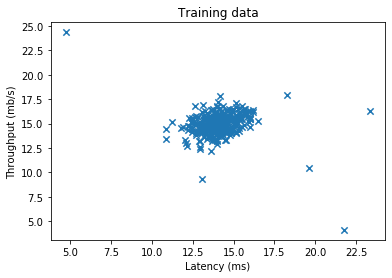

In [6]:
# Visualizing the data
plt.scatter(X[:, 0], X[:, 1], marker='x', s=40)
plt.title('Training data')
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

In [7]:
mu, sigma2 = estimate_gaussian(X)
print(mu.shape)
print(sigma2.shape)

(2, 1)
(2, 1)


In [8]:
# Training set
p = multivariate_gaussian(X, mu, sigma2)
print(p.shape)

(307, 1)


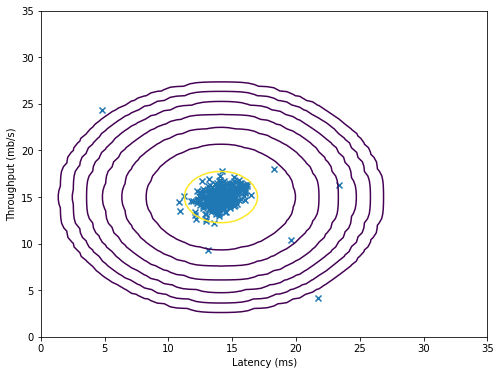

In [9]:
# Visualize the fit
plt.figure(figsize=(8, 6))

# plotting data
plt.scatter(X[:, 0], X[:, 1], marker='x')

# plotting contour
u, v = np.linspace(0, 35, 70), np.linspace(0, 35, 70)
z = np.empty((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = multivariate_gaussian(np.array([u[i], v[j]]), mu, sigma2)

contour_level = 10 ** np.arange(-20,0,3,dtype=np.float)
plt.contour(u, v, z.T, contour_level)

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

In [10]:
# CV set
p_val = multivariate_gaussian(X_val, mu, sigma2)

# Find best threshold
epsilon, f1 = select_threshold(y_val, p_val)
print(f'Best epsilon found in cv set : {epsilon}')
print(f'Best F1 score in cv set : {f1}')

Best epsilon found in cv set : 8.990852779269496e-05
Best F1 score in cv set : 0.8750000000000001


<ipython-input-4-f1bf7fbfe5c8>:21: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


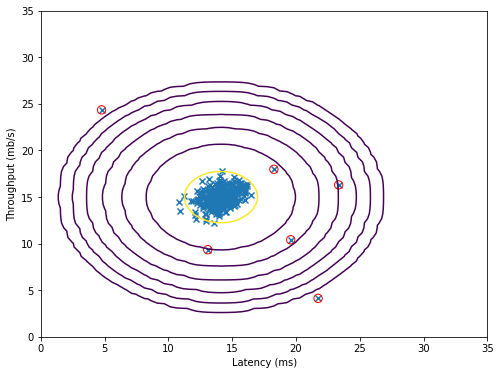

In [11]:
#Visualize the anomalies
plt.figure(figsize=(8, 6))

# plotting data
plt.scatter(X[:, 0], X[:, 1], marker='x')

# plotting contour
u, v = np.linspace(0, 35, 70), np.linspace(0, 35, 70)
z = np.empty((len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        z[i, j] = multivariate_gaussian(np.array([u[i], v[j]]), mu, sigma2)

contour_level = 10 ** np.arange(-20,0,3,dtype=np.float)
plt.contour(u, v, z.T, contour_level)

# anomalies
outliers = np.nonzero(p < epsilon)[0]
plt.scatter(X[outliers, 0], X[outliers, 1], marker='o', facecolor='none', edgecolor='r', s=70)

plt.xlim(0,35)
plt.ylim(0,35)
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

#### High Dimensional Dataset

In [12]:
mat2 = loadmat('..\datasets\ex8data2.mat')
X2 = mat2['X']
X2_val = mat2['Xval']
y2_val = mat2['yval']
print(X2.shape)
print(X2_val.shape, y2_val.shape)

(1000, 11)
(100, 11) (100, 1)


In [13]:
# Compute mean and variance
mu_2, sigma2_2 = estimate_gaussian(X2)
print(mu_2.shape)
print(sigma2_2.shape)

(11, 1)
(11, 1)


In [15]:
# Training set
p2 = multivariate_gaussian(X2, mu_2, sigma2_2)

In [16]:
# CV set
p2_val = multivariate_gaussian(X2_val, mu_2, sigma2_2)

# Find best threshold
epsilon_2, f1_2 = select_threshold(y2_val, p2_val)
print(f'Best epsilon found in cv set : {epsilon_2}')
print(f'Best F1 score in cv set : {f1_2}')

Best epsilon found in cv set : 1.377228890761358e-18
Best F1 score in cv set : 0.6153846153846154


<ipython-input-4-f1bf7fbfe5c8>:21: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


In [17]:
# Total anomaies
print(f'Outliers found : {np.sum(p2 < epsilon_2)}')

Outliers found : 117
